# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

File has been downloaded directly.

In [1]:
# import libraries
import json
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# open the 'twitter_archive_enhanced.csv' file
# twitter_archive_enhanced = archive

archive = pd.read_csv('twitter_archive_enhanced.csv')

archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
folder_name = 'data_wrangling_project'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [10]:
response

<Response [200]>

In [5]:
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

In [6]:
image = pd.read_csv('data_wrangling_project/image-predictions.tsv', sep='\t')

image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [7]:
df_list = []

with open('tweet_json.txt', 'r') as file:
    for line in file:
        tweets = json.loads(line)
        tweet_id = tweets['id']
        retweet_count = tweets['retweet_count']
        favorite_count = tweets['favorite_count']
        df_list.append({'tweets': tweets,
                        'tweet_id': tweet_id,
                        'retweet_count': retweet_count,
                        'favorite_count': favorite_count})

        tweet = pd.DataFrame(df_list, columns = ['tweets', 'tweet_id', 'retweet_count', 'favorite_count'])

In [8]:
tweet.head()

,tweets,tweet_id,retweet_count,favorite_count
0,{'created_at': 'Tue Aug 01 16:23:56 +0000 2017...,892420643555336193,8853,39467
1,{'created_at': 'Tue Aug 01 00:17:27 +0000 2017...,892177421306343426,6514,33819
2,{'created_at': 'Mon Jul 31 00:18:03 +0000 2017...,891815181378084864,4328,25461
3,{'created_at': 'Sun Jul 30 15:58:51 +0000 2017...,891689557279858688,8964,42908
4,{'created_at': 'Sat Jul 29 16:00:24 +0000 2017...,891327558926688256,9774,41048


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



Visual Assessment

In [9]:
image

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [10]:
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [12]:
tweet

,tweets,tweet_id,retweet_count,favorite_count
0,{'created_at': 'Tue Aug 01 16:23:56 +0000 2017...,892420643555336193,8853,39467
1,{'created_at': 'Tue Aug 01 00:17:27 +0000 2017...,892177421306343426,6514,33819
2,{'created_at': 'Mon Jul 31 00:18:03 +0000 2017...,891815181378084864,4328,25461
3,{'created_at': 'Sun Jul 30 15:58:51 +0000 2017...,891689557279858688,8964,42908
4,{'created_at': 'Sat Jul 29 16:00:24 +0000 2017...,891327558926688256,9774,41048
5,{'created_at': 'Sat Jul 29 00:08:17 +0000 2017...,891087950875897856,3261,20562
6,{'created_at': 'Fri Jul 28 16:27:12 +0000 2017...,890971913173991426,2158,12041
7,{'created_at': 'Fri Jul 28 00:22:40 +0000 2017...,890729181411237888,16716,56848
8,{'created_at': 'Thu Jul 27 16:25:51 +0000 2017...,890609185150312448,4429,28226
9,{'created_at': 'Wed Jul 26 15:59:51 +0000 2017...,890240255349198849,7711,32467


In [13]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweets            2354 non-null object
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


Programmatic Assessment

In [10]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
archive[archive['rating_numerator'] == 1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


In [7]:
archive[archive['retweeted_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [7]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
archive[archive['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [10]:
archive.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
810,771380798096281600,NaN,NaN,2016-09-01 16:14:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Fizz. She thinks love is a social constru...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/771380798...,11,10,Fizz,None,None,None,None
847,766078092750233600,NaN,NaN,2016-08-18 01:03:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Colby. He's currently r...,7.258423e+17,4.196984e+09,2016-04-29 00:21:01 +0000,https://twitter.com/dog_rates/status/725842289...,12,10,Colby,None,None,None,None
2163,669375718304980992,NaN,NaN,2015-11-25 04:43:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Billl. He's trying to be a ghost but h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669375718...,6,10,Billl,None,None,None,None
1572,687664829264453632,NaN,NaN,2016-01-14 15:57:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Opal. He's a Belgian Dijon Poofster. Upse...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687664829...,11,10,Opal,None,None,None,None
648,793120401413079041,NaN,NaN,2016-10-31 16:00:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Robin. She's desperately trying to do ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793120401...,11,10,Robin,None,None,None,None
955,751598357617971201,NaN,NaN,2016-07-09 02:06:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Toby. A cat got his tongue. 13/10 ador...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751598357...,13,10,Toby,None,None,None,None
1169,720785406564900865,NaN,NaN,2016-04-15 01:26:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He hears everything you say. D...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/720785406...,12,10,Archie,None,None,None,None
1367,702598099714314240,NaN,NaN,2016-02-24 20:56:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sansa. She's gotten too big for her ch...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/702598099...,11,10,Sansa,None,None,pupper,None
1186,718540630683709445,NaN,NaN,2016-04-08 20:46:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Get you a pup that can do both. 10/10 https://...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/718540630...,10,10,None,None,None,None,None
696,786664955043049472,NaN,NaN,2016-10-13 20:28:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Honestly Kathleen I just want more Ken Bone"" ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786664955...,12,10,None,None,None,None,None


In [19]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [21]:
image.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,0.271485,False,gar,0.189945,False
144,668623201287675904,https://pbs.twimg.com/media/CUdtP1xUYAIeBnE.jpg,4,Chihuahua,0.708163,True,Pomeranian,0.091372,True,titi,0.067325,False
1381,765371061932261376,https://pbs.twimg.com/media/Cp8k6oRWcAUL78U.jpg,2,golden_retriever,0.829456,True,Labrador_retriever,0.089371,True,kuvasz,0.017028,True
1609,801115127852503040,https://pbs.twimg.com/media/Cx4h7zHUsAAqaJd.jpg,1,dalmatian,0.823356,True,English_setter,0.094602,True,bluetick,0.021953,True
1236,746726898085036033,https://pbs.twimg.com/media/ClzoJz7WYAELHSf.jpg,1,golden_retriever,0.256505,True,Labrador_retriever,0.252417,True,seat_belt,0.203163,False
608,680070545539371008,https://pbs.twimg.com/media/CW-dU34WQAANBGy.jpg,1,earthstar,0.127701,False,Shih-Tzu,0.121811,True,bubble,0.117820,False
416,674019345211760640,https://pbs.twimg.com/media/CVqZBO8WUAAd931.jpg,1,collie,0.992732,True,borzoi,0.005043,True,Shetland_sheepdog,0.001725,True
143,668620235289837568,https://pbs.twimg.com/media/CUdqjvAWUAANfoU.jpg,1,crash_helmet,0.757942,False,toaster,0.037497,False,mouse,0.027271,False
1796,831322785565769729,https://pbs.twimg.com/media/C4lzqQ4UEAApzU0.jpg,1,Old_English_sheepdog,0.999715,True,Tibetan_terrier,0.000046,True,guinea_pig,0.000041,False
1903,851953902622658560,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True


### Quality issues

#### 'archive' table

1. Erroneous datatype: timestamp should be datetime and not a string

2. Erroneous datatype: retweeted_status_timestamp should be datetime and not a string

3. Erroneous datatype: tweet_id should be string and not int64

4. rating_numerator == 1776 and denominator is 10. This is not consistent with the rest of the data, I assume the numerator should be 17

5. rating_numerator was extracted as 75 instead of 9.75.

#### 'image' table

6. tweet_id should be string and not int64

7. img_num should be string and not int64

#### 'tweet' table


8. tweet_id should be string and not int64


### Tidiness issues
1. doggo, floofer, pupper, puppo columns on the 'archive' table should be a column

2. All three datasets should be merged on tweet_id into one

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [9]:
# Make copies of original pieces of data
archive_clean = archive.copy()

tweet_clean = tweet.copy()

image_clean = image.copy()

In [10]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
#remove retweets
archive_clean = archive_clean[archive_clean.retweeted_status_id.isnull()]

In [12]:
#remove retweets
archive_clean = archive_clean[archive_clean.retweeted_status_user_id.isnull()]

In [13]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [14]:
#remove retweets
archive_clean = archive_clean[archive_clean.retweeted_status_timestamp.isnull()]

In [15]:
archive_clean.head(300)

archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

### Issue #1: Erroneous datatype: 'timestamp' in the Archive table should be datetime and not a string

#### Define: In the 'archive' table, the timestamp's datatype is a string, however, it should be in datetime format

#### Code

In [20]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

#### Test

In [21]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[ns](1), flo

### Issue #2: Erroneous datatype: 'retweeted_status_timestamp' in the Archive table should be datetime and not a string

#### Define: In the 'archive' table, the retweeted_status_timestamp' datatype is a string, however, it should be in datetime format

#### Code

In [23]:
archive_clean['retweeted_status_timestamp'] = pd.to_datetime(archive_clean['retweeted_status_timestamp'])

#### Test

In [24]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[ns]

### Issue #3: Erroneous datatype: 'tweet_id' in the Archive table should be a string and not an integer

#### Define: In the 'archive' table, the 'tweet_id' datatype is an integer, it's supposed to be a string.

In [25]:
archive_clean['tweet_id'] = archive_clean['tweet_id'].astype(str)

#### Test

In [26]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[ns

### Issue #4: Erroneous datatype: 'rating_numerator' == 1776 and denominator is 10. This is not consistent with the rest of the data, I assume the numerator should be 17

#### Define: In the 'archive' table, 'rating_numerator' a rating has a numerator of 1776, this is very inconsistent with the rest of the data. I want to replace 1776 with 17.

#### Code

In [27]:
archive_clean['rating_numerator'].replace({1776: 17}, inplace =  True)

#### Test

In [28]:
archive_clean[archive_clean['rating_numerator'] == 1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Issue #5: rating_numerator was extracted as 75 instead of 9.75.

#### Define: In the 'archive' table, an observation with 'rating_numerator' of 9.75 was erroneously extracted as 75. This 75 will be replaced with 9.75

### Code

In [29]:
archive_clean['rating_numerator'].replace({75: 9.75}, inplace =  True)

#### Test

In [27]:
archive_clean[archive_clean['rating_numerator'] == 75]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Issue #6: Erroneous datatype: 'tweet_id' in the Image table should be a string and not an integer

#### Define: In the 'archive' table, the 'tweet_id' datatype is an integer, it's supposed to be a string.

### Code

In [30]:
image_clean['tweet_id'] = image_clean['tweet_id'].astype(str)

#### Test

In [39]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### Issue #7: Erroneous datatype: 'img_num' in the Image table should be a string and not an integer

#### Define: In the 'image' table, the 'img_num' datatype is an integer, it's supposed to be a string

### Code

In [31]:
image_clean['img_num'] = image_clean['img_num'].astype(str)

#### Test

In [32]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null object
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), object(6)
memory usage: 152.1+ KB


### Issue #8: Erroneous datatype: 'tweet_id' in the tweet table should be a string and not an integer

#### Define: In the 'tweet' table, the 'tweet_id' datatype is an integer, it's supposed to be a string

### Code

In [33]:
tweet_clean['tweet_id'] = tweet_clean['tweet_id'].astype(str)

#### Test

In [52]:
tweet_clean.info()

tweet_clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweets            2354 non-null object
tweet_id          2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(2), object(2)
memory usage: 73.6+ KB


,tweets,tweet_id,retweet_count,favorite_count
0,{'created_at': 'Tue Aug 01 16:23:56 +0000 2017...,892420643555336193,8853,39467
1,{'created_at': 'Tue Aug 01 00:17:27 +0000 2017...,892177421306343426,6514,33819
2,{'created_at': 'Mon Jul 31 00:18:03 +0000 2017...,891815181378084864,4328,25461
3,{'created_at': 'Sun Jul 30 15:58:51 +0000 2017...,891689557279858688,8964,42908
4,{'created_at': 'Sat Jul 29 16:00:24 +0000 2017...,891327558926688256,9774,41048
5,{'created_at': 'Sat Jul 29 00:08:17 +0000 2017...,891087950875897856,3261,20562
6,{'created_at': 'Fri Jul 28 16:27:12 +0000 2017...,890971913173991426,2158,12041
7,{'created_at': 'Fri Jul 28 00:22:40 +0000 2017...,890729181411237888,16716,56848
8,{'created_at': 'Thu Jul 27 16:25:51 +0000 2017...,890609185150312448,4429,28226
9,{'created_at': 'Wed Jul 26 15:59:51 +0000 2017...,890240255349198849,7711,32467


### Tidiness Issue 1: doggo, floofer, pupper, puppo columns on the 'archive' table should be a column

#### Define: doggo, floofer, pupper, puppo columns on the 'archive' table should be a column. This would be corrected using the melt function

### Code

In [34]:
archive_clean = pd.melt(archive_clean, id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name'],
                           var_name='dog_stages')

In [35]:
archive_clean = archive_clean.drop('value', axis=1)

In [36]:
#remove duplicates
archive_clean.drop_duplicates()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,doggo
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,doggo
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,doggo
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,doggo
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,doggo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950...,13.0,10,None,doggo
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaT,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10,Jax,doggo
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890729181...,13.0,10,None,doggo
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890609185...,13.0,10,Zoey,doggo
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890240255...,14.0,10,Cassie,doggo


### Test

In [37]:
archive_clean.sample(200)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
3732,679722016581222400,NaN,NaN,2015-12-23 17:55:32,"<a href=""http://twitter.com/download/iphone"" r...",This is Mike. He is a Jordanian Frito Pilates....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/679722016...,8.0,10,Mike,floofer
3033,744995568523612160,NaN,NaN,2016-06-20 20:49:19,"<a href=""http://twitter.com/download/iphone"" r...",This is Abby. She got her face stuck in a glas...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/744995568...,9.0,10,Abby,floofer
132,863062471531167744,NaN,NaN,2017-05-12 16:05:02,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Quinn. She's quite the goofball. ...,NaN,NaN,NaT,"https://www.gofundme.com/helpquinny,https://tw...",13.0,10,Quinn,doggo
8477,670086499208155136,NaN,NaN,2015-11-27 03:47:25,"<a href=""http://twitter.com/download/iphone"" r...","""Hi yes this is dog. I can't help with that s-...",NaN,NaN,NaT,https://twitter.com/dog_rates/status/670086499...,10.0,10,None,puppo
1047,714141408463036416,NaN,NaN,2016-03-27 17:25:54,"<a href=""http://twitter.com/download/iphone"" r...","I know we only rate dogs, but since it's Easte...",NaN,NaN,NaT,https://twitter.com/dog_rates/status/714141408...,10.0,10,None,doggo
2986,749064354620928000,NaN,NaN,2016-07-02 02:17:13,"<a href=""http://twitter.com/download/iphone"" r...",Meet Winston. He's pupset because I forgot to ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/749064354...,11.0,10,Winston,floofer
8228,674999807681908736,6.747934e+17,4.196984e+09,2015-12-10 17:11:09,"<a href=""http://twitter.com/download/iphone"" r...",Ok last one of these. I may try to make some m...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/674999807...,13.0,10,None,puppo
4850,796080075804475393,NaN,NaN,2016-11-08 20:00:55,"<a href=""http://twitter.com/download/iphone"" r...",This is Yogi. He's 98% floof. Snuggable af. 12...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/796080075...,12.0,10,Yogi,pupper
4149,669661792646373376,NaN,NaN,2015-11-25 23:39:47,"<a href=""http://twitter.com/download/iphone"" r...",This is a brave dog. Excellent free climber. T...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/669661792...,5.0,10,a,floofer
1168,704364645503647744,NaN,NaN,2016-02-29 17:56:32,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Bisquick. He's a Beneplop Cumbers...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/704364645...,12.0,10,Bisquick,doggo


In [38]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8700 entries, 0 to 8699
Data columns (total 14 columns):
tweet_id                      8700 non-null object
in_reply_to_status_id         312 non-null float64
in_reply_to_user_id           312 non-null float64
timestamp                     8700 non-null datetime64[ns]
source                        8700 non-null object
text                          8700 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 8468 non-null object
rating_numerator              8700 non-null float64
rating_denominator            8700 non-null int64
name                          8700 non-null object
dog_stages                    8700 non-null object
dtypes: datetime64[ns](2), float64(5), int64(1), object(6)
memory usage: 951.6+ KB


### Tidiness Issue 2: Too many datasets

#### Define: All three datasets should be merged on tweet_id into one

### Code

In [39]:
archive_tweet_clean = pd.merge(archive_clean, tweet_clean,
                            on=['tweet_id'], how='left')

In [40]:
werate_tweet_archive_clean = pd.merge(archive_tweet_clean, image_clean,
                            on=['tweet_id'], how='left')

### Test

In [41]:
werate_tweet_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950...,...,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaT,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890729181...,...,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890609185...,...,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890240255...,...,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


In [42]:
werate_tweet_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8700 entries, 0 to 8699
Data columns (total 28 columns):
tweet_id                      8700 non-null object
in_reply_to_status_id         312 non-null float64
in_reply_to_user_id           312 non-null float64
timestamp                     8700 non-null datetime64[ns]
source                        8700 non-null object
text                          8700 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 8468 non-null object
rating_numerator              8700 non-null float64
rating_denominator            8700 non-null int64
name                          8700 non-null object
dog_stages                    8700 non-null object
tweets                        8700 non-null object
retweet_count                 8700 non-null int64
favorite_count                8700 non-null int64
jpg_url            

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [43]:
werate_tweet_archive_clean.to_csv('twitter_archive_master.csv', index = 'false')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [12]:
df = pd.read_csv('twitter_archive_master.csv')

df

,Unnamed: 0,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
5,5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,...,1.0,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
6,6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,...,1.0,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
7,7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,...,2.0,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
8,8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,...,1.0,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
9,9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,...,1.0,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


In [3]:
dog_stages_distr = df.dog_stages.value_counts()

dog_stages_distr

floofer    2175
doggo      2175
puppo      2175
pupper     2175
Name: dog_stages, dtype: int64

In [4]:
p1_pred = df.p1.value_counts()[0:10].sort_values()

p1_pred

malamute              116
toy_poodle            152
Pomeranian            152
Samoyed               160
chow                  164
pug                   216
Chihuahua             316
Pembroke              352
Labrador_retriever    380
golden_retriever      556
Name: p1, dtype: int64

In [64]:
# calculate dog ratings
rating = df['rating_numerator']/df['rating_denominator']

rating[0:10]

0    1.3
1    1.3
2    1.2
3    1.3
4    1.2
5    1.3
6    1.3
7    1.3
8    1.3
9    1.4
dtype: float64

### Insights:
1. From the outcome of 'dog_stages_distri', the dog stages are equally distributed with each having 2,175 value counts.

2. The top 10 prediction from the images are golden_retriever, Labrador_retriever, Pembroke, Chihuahua, pug, chow, Samoyed,  Pomeranian, toy_poodle, malamute with values ranging from 116 to 556.

3. The highest prediction is golden_retriever with a total of 556 values.

4. The top 10 ratings range from the values of 1.2 to 1.4 with 1.3 being the most frequent.

### Visualization

Text(0.5,0,'dog_stages')

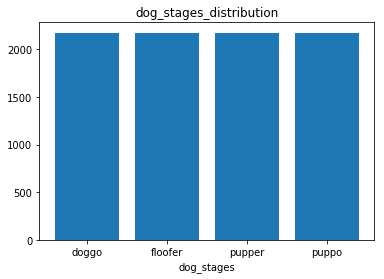

In [5]:
names = dog_stages_distr.index
fig, ax = plt.subplots()
ax.bar(dog_stages_distr.index, dog_stages_distr);
ax.set_title('dog_stages_distribution')
ax.set_xlabel('dog_stages')

Text(0.5,0,' Algorithm No. 1 Prediction')

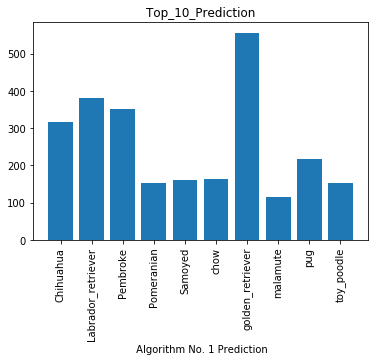

In [6]:
pred = p1_pred.index
fig, ax = plt.subplots()
ax.bar(pred, p1_pred);
plt.xticks(rotation=90);
ax.set_title('Top_10_Prediction')
ax.set_xlabel(' Algorithm No. 1 Prediction' )

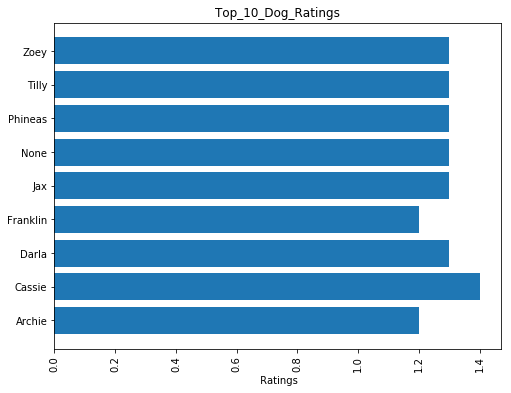

In [65]:
x = df['name'][0:10]
y = rating[0:10]

fig, ax = plt.subplots()
ax.barh(x, y);
plt.xticks(rotation=90);
ax.set_title('Top_10_Dog_Ratings')
ax.set_xlabel(' Ratings' )

plt.show()